In [3]:
# Learn basics of neural Networks first
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler# standard scaler is less sensitive to outliers, while minmax scaler is more sesnitive 
# x_sclaed=(X-xmin)/(xmax-xmin), this is the formulae for minmax scaler
# standard sclaer has formulae of (x-mean(X)/std(X))
from tensorflow.keras.models import Sequential,load_model
# sequential allow us to makes layers of neural network with different activation functions 
from tensorflow.keras.layers import LSTM,Dense,Dropout
# Lstm is the main layer, Dense allow us to add layers and dropout(helps remove overfitting) allow us to remove layers 
import os 
import tensorflow as tf 
tf.__version__

'2.11.0'

In [3]:
df=pd.read_csv('apple.csv')

In [4]:
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,67.7142,68.4014,66.8928,67.8542,158168416,AAPL
1,2013-02-11,68.0714,69.2771,67.6071,68.5614,129029425,AAPL
2,2013-02-12,68.5014,68.9114,66.8205,66.8428,151829363,AAPL
3,2013-02-13,66.7442,67.6628,66.1742,66.7156,118721995,AAPL
4,2013-02-14,66.3599,67.3771,66.2885,66.6556,88809154,AAPL


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    1259 non-null   object 
 1   open    1259 non-null   float64
 2   high    1259 non-null   float64
 3   low     1259 non-null   float64
 4   close   1259 non-null   float64
 5   volume  1259 non-null   int64  
 6   Name    1259 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 69.0+ KB


In [6]:
df['volatality']=df['high']-df['low']

In [7]:
df.tail()

,date,open,high,low,close,volume,Name,volatality
1254,2018-02-01,167.165,168.62,166.7600,167.78,47230787,AAPL,1.8600
1255,2018-02-02,166.000,166.80,160.1000,160.50,86593825,AAPL,6.7000
1256,2018-02-05,159.100,163.88,156.0000,156.49,72738522,AAPL,7.8800
1257,2018-02-06,154.830,163.72,154.0000,163.03,68243838,AAPL,9.7200
1258,2018-02-07,163.085,163.40,159.0685,159.54,51608580,AAPL,4.3315


In [8]:
# a tensor is fancy word for a multidimensional array 
data=df['open'].values# will convert this to numpy array 

In [9]:
data.shape
# it' stored in rows and we need it in columns

(1259,)

In [10]:
# but we need it in the (1259,1) format 
data=data.reshape(-1,1)

In [11]:
data

array([[ 67.7142],
       [ 68.0714],
       [ 68.5014],
       ...,
       [159.1   ],
       [154.83  ],
       [163.085 ]])

In [12]:
data_train=np.array(data[:int(data.shape[0]*0.8)])
data_test=np.array(data[int(data.shape[0]*0.8)-50:])
# so we have 50 more values in the test dataset so as to use 50 days data to predict the 51st day of the stock price 

In [13]:
scaler=MinMaxScaler(feature_range=(0,1))
# the scaler transform the values between 0 and 1 

In [14]:
scaled_train=scaler.fit_transform(data_train)

In [15]:
scaled_train

array([[0.15550899],
       [0.16002875],
       [0.16546966],
       ...,
       [0.9222455 ],
       [0.93262121],
       [0.95046235]])

In [16]:
scaled_test=scaler.transform(data_test)

In [17]:
def create_my_dataset(data):
    x=[]
    y=[]
    for i in range(50,data.shape[0]):
        # from 50 to number of rows in the dataset
        x.append(data[i-50:i,0])
        y.append(data[i,0])
        # this will give a single value out in the data 
    x=np.array(x)
    y=np.array(y)
    return x,y

In [18]:
x_train,y_train=create_my_dataset(scaled_train)

In [19]:
x_test,y_test=create_my_dataset(scaled_test)

In [20]:
y_train[1]
# so basically it has 957 rows of data with 50 coulumns stored row wise for each value 

0.010068226564833083

In [21]:
scaled_train[51]

array([0.01006823])

In [22]:
# So in total for our set we have 50 values in each rowwise distribution of our data and in the y wehave the 51 st value stored
# similar composition will be with the test data 

In [23]:
# define window size and step size
#window_size = 3
#step_size = 1

# create a sliding window using rolling and shift
# windowed_data = pd.concat([data.shift(i).rolling(window_size) for i in range(window_size)], axis=1).dropna()

# print(windowed_data)
# will look in this a little later 


In [24]:
x_train.shape
# but we want to the dataset as (957,50,1), where 1 is for features
x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_test=np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [33]:
model = Sequential()
# this wil allow us to add data layers by layers 
model.add(LSTM(units=96,return_sequences=True,input_shape=(x_train.shape[1],1)))# the units is the amaount of the neurons
# if we increase the neurons will increase the overfitting and will also increase time complexity 
# we never put the rows in the input_shape variable 
# we have used this return sequences as true, so that if we want to add anothe layer of neurons later on 
# the input shapes tell us that we have 50 values from training data and 1 feature 
model.add(Dropout(0.2))# It help us reduce the overfitting, by eleiminating 20% of the neurons 
model.add(LSTM(units=96,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96))
# we don't need to return here because we will not have more than this 
model.add(Dropout(0.2))
model.add(Dense(units=1))
# this will give us 1 output



In [34]:
model.summary()
# we don't know what the data is but we have the shape of the data here  

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 50, 96)            37632     
                                                                 
 dropout_3 (Dropout)         (None, 50, 96)            0         
                                                                 
 lstm_4 (LSTM)               (None, 50, 96)            74112     
                                                                 
 dropout_4 (Dropout)         (None, 50, 96)            0         
                                                                 
 lstm_5 (LSTM)               (None, 96)                74112     
                                                                 
 dropout_5 (Dropout)         (None, 96)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [35]:
model.compile(loss='mean_squared_error',optimizer='adam')
# the model will be trained on loss function here and model will then find out the weights in the networok withn help of the optiizer


In [38]:
if (not os.path.exists('C:\\Users\\100850993\\Desktop\\AI-Project\\stockpredictions.h5')):
     model.fit(x_train,y_train,epochs=50,batch_size=32)
     model.save('C:\\Users\\100850993\\Desktop\\AI-Project\\stockpredictions.h5')
# epochs means we go thorugh the whole training data 50 times and in one go of the network we will go through 32 examples
# so in total epochs means if I have a dataset with 1000 samples than epoch of 50 means that the model will see the entire 
# datset 50 times during the training process and batch size means that after every 32 samples the model will update it's parameters
# we are saving the model here so that we can later use it 

Epoch 1/50
30/30 [==============================] - 10s 111ms/step - loss: 0.0449
Epoch 2/50
30/30 [==============================] - 3s 112ms/step - loss: 0.0059
Epoch 3/50
30/30 [==============================] - 3s 107ms/step - loss: 0.0049
Epoch 4/50
30/30 [==============================] - 3s 107ms/step - loss: 0.0046
Epoch 5/50
30/30 [==============================] - 3s 112ms/step - loss: 0.0049
Epoch 6/50
30/30 [==============================] - 3s 116ms/step - loss: 0.0055
Epoch 7/50
30/30 [==============================] - 4s 118ms/step - loss: 0.0043
Epoch 8/50
30/30 [==============================] - 3s 113ms/step - loss: 0.0040
Epoch 9/50
30/30 [==============================] - 3s 114ms/step - loss: 0.0040
Epoch 10/50
30/30 [==============================] - 3s 116ms/step - loss: 0.0045
Epoch 11/50
30/30 [==============================] - 3s 115ms/step - loss: 0.0037
Epoch 12/50
30/30 [==============================] - 3s 111ms/step - loss: 0.0035
Epoch 13/50
30/30 [=====

In [40]:
predict=model.predict(x_test)
predict = scaler.inverse_transform(predict)
# here we get the original values in $ terms 

8/8 [==============================] - 0s 41ms/step


In [246]:
x_test

array([[[0.7048619 ],
        [0.70865789],
        [0.70043325],
        ...,
        [0.9222455 ],
        [0.93262121],
        [0.95046235]],

       [[0.70865789],
        [0.70043325],
        [0.71080895],
        ...,
        [0.93262121],
        [0.95046235],
        [0.96071152]],

       [[0.70043325],
        [0.71080895],
        [0.69518213],
        ...,
        [0.95046235],
        [0.96071152],
        [0.96450751]],

       ...,

       [[1.45963093],
        [1.49227643],
        [1.51429316],
        ...,
        [1.41015655],
        [1.41388927],
        [1.39914818]],

       [[1.49227643],
        [1.51429316],
        [1.5136605 ],
        ...,
        [1.41388927],
        [1.39914818],
        [1.31184045]],

       [[1.51429316],
        [1.5136605 ],
        [1.50417053],
        ...,
        [1.39914818],
        [1.31184045],
        [1.25781088]]])

range(1007, 1259)


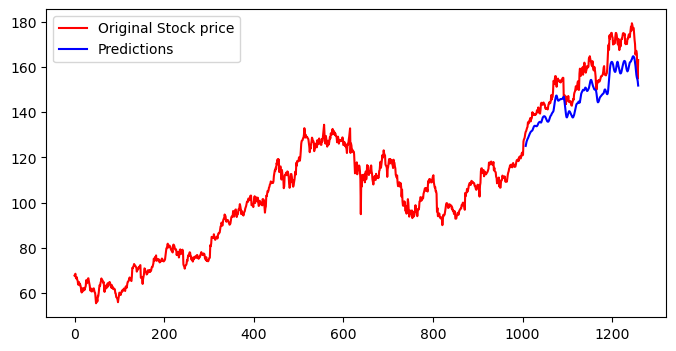

In [45]:
fig,ax=plt.subplots(figsize=(8,4))
plt.plot(data,color='red',label='Original Stock price')
ax.plot(range(len(y_train)+50,len(y_train)+len(predict)+50),predict,color='blue',label='Predictions')
plt.legend()
print(range(len(y_train)+50,len(y_train)+len(predict)+50))
# so we are able to predict the prices but they are a little low 

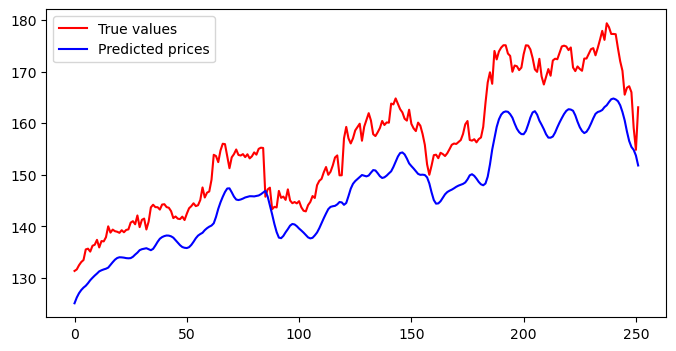

In [46]:
y_test_scaled= scaler.inverse_transform(y_test.reshape(-1,1))
# we will always have to use a shape like (1,2) in the transform functions
fig,ax = plt.subplots(figsize=(8,4))
ax.plot(y_test_scaled,color ='red',label='True values')
plt.plot(predict,color='blue',label='Predicted prices')
plt.legend()

# Sentiment Analysis 

In [64]:
sen_data=pd.read_csv('tweets.csv')

In [65]:
import random

In [66]:
sen_data.head()
# we need shuffle data in this 


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [104]:
# random.shuffle(sen_data), not working 
sen_data = sen_data.sample(frac=1).reset_index(drop=True)# this will drop the index that will be generated by this method
# here the whole data is shuffled and with a fraction of complete 1, this let us keep the full dataset 

In [105]:
from sklearn.model_selection import train_test_split
import re # regular expression 
from keras.layers import Embedding
from keras.preprocessing.text import Tokenizer # it will split the sentences in words
from keras.utils import pad_sequences # pad_sequences make our reviews of the customer of same length

In [106]:
sen_data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,568793221809250304,negative,1.0000,Customer Service Issue,1.0000,US Airways,NaN,FrancisDeana,NaN,0,@USAirways I already let them know and sent 4 ...,NaN,2015-02-20 07:24:06 -0800,NaN,NaN
1,568116895305617409,negative,0.6511,Lost Luggage,0.6511,US Airways,NaN,seungminkim,NaN,0,"@USAirways I hope so, too. Thank you for your ...",NaN,2015-02-18 10:36:37 -0800,"Washington, D.C.",Quito
2,568509669758660608,neutral,1.0000,NaN,NaN,Delta,NaN,HAbbott4,NaN,0,@JetBlue Just sent it,NaN,2015-02-19 12:37:22 -0800,NY,Eastern Time (US & Canada)
3,569608866138173440,negative,0.6545,Bad Flight,0.3335,United,NaN,timdrewitt,NaN,0,@United Personal Device Entertainment system i...,NaN,2015-02-22 13:25:11 -0800,Aylesbury United Kingdom,London
4,569976426163777536,negative,1.0000,Lost Luggage,1.0000,United,NaN,tiffy_mac,NaN,0,@united you are easily the worst company I hav...,NaN,2015-02-23 13:45:44 -0800,"Brighton, UK\n",NaN


In [107]:
sen_data.shape

(14640, 15)

In [108]:
# In this data we only need text columns which will serve as the input of the LSTM and we need te airline sentiment columns which 
# we will predict based of the text, so as to train our model and then get an airline sentiment 

In [109]:
sen_data_updated=sen_data[['airline_sentiment','text']]

In [110]:
sen_data_updated.head()

,airline_sentiment,text
0,negative,@USAirways I already let them know and sent 4 ...
1,negative,"@USAirways I hope so, too. Thank you for your ..."
2,neutral,@JetBlue Just sent it
3,negative,@United Personal Device Entertainment system i...
4,negative,@united you are easily the worst company I hav...


<AxesSubplot:ylabel='Frequency'>

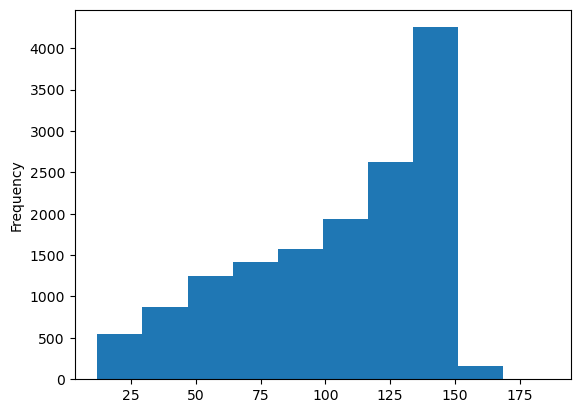

In [111]:
sen_data_updated['text'].str.len().plot.hist()# here we calculated each string length and then we are plotting it 
# this tells us thaht modt of the tweets are in the range of 130 to 150 

<AxesSubplot:>

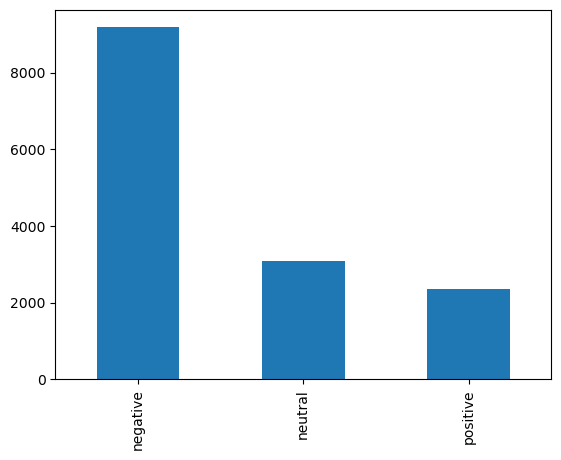

In [112]:
sen_data_updated['airline_sentiment'].value_counts().plot.bar()

In [113]:
# preprocessing the data 

In [114]:
sen_data_updated['text']=sen_data_updated['text'].apply(lambda x : x.lower())
sen_data_updated['text'] = sen_data_updated['text'].apply( lambda x: re.sub('[^a-z A-Z 0-9 \s]',"",x))
# re.sub('[^a-z 0-9 \s]') this defines what all we want to keep in our data, and all the characters in the list that 
# doesn't matches these strings will be pushed out. ^ is basically a not. and the symbols that are not needed we will replace 
# it with nothing and we are appling it in the each and every x 

C:\Users\100850993\AppData\Local\Temp\ipykernel_7736\3730428147.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sen_data_updated['text'] = sen_data_updated['text'].apply( lambda x: re.sub('[^a-z A-Z 0-9 \s]',"",x))


In [130]:
sen_data_updated['text'].head()

0    USAirways I already let them know and sent 4 c...
1    USAirways I hope so too Thank you for your hel...
2                                 JetBlue Just sent it
3    United Personal Device Entertainment system is...
4    united you are easily the worst company I have...
Name: text, dtype: object

In [131]:
# we will now convert the data using tokenizer to numbers, but first we need words 

In [132]:
tokenizer = Tokenizer(num_words=5000, split= " ")# if the word is not having 5000 enteries at most therwise it won't be considered 
# num_words is the maximum number of words we accept, it will only keep the 5000 most frequent words and we split the data 
# with the space 

In [133]:
sen_data_updated['text']

0        USAirways I already let them know and sent 4 c...
1        USAirways I hope so too Thank you for your hel...
2                                     JetBlue Just sent it
3        United Personal Device Entertainment system is...
4        united you are easily the worst company I have...
                               ...                        
14635    JetBlue Yep 1 hour at Logan Gangway broke and ...
14636    southwestair thanks for taking it up a notch l...
14637    USAirways Good grief Flight Cancelled Flightle...
14638    USAirways help im falling out of one of your p...
14639    virginamerica hows a direct flight FLLgtSFO ha...
Name: text, Length: 14640, dtype: object

In [134]:
tokenizer.fit_on_texts(sen_data_updated['text'].values)
# valuess will transfer an array that's why it is used 

In [223]:
type(sen_data_updated['text'])

pandas.core.series.Series

In [135]:
x=tokenizer.texts_to_sequences(sen_data_updated['text'].values)

In [154]:
# x is now a nested list filled with numbers that represent the frequency of words

In [153]:
for i in range(len(x)):
    print(x[i])

[12, 3, 216, 199, 155, 108, 10, 205, 139, 955, 92, 4, 84, 79, 289, 58, 3, 23, 2455, 10, 71, 14, 28, 473, 84, 79]
[12, 3, 273, 44, 167, 68, 6, 7, 21, 46, 185, 1691, 3092, 1311, 2, 3093, 10, 41, 1692, 203, 1161]
[17, 41, 205, 20]
[5, 1162, 2054, 981, 260, 14, 114, 31, 25, 316, 2718, 301, 4598, 291, 48, 593, 64, 283, 7, 39]
[5, 6, 35, 1508, 2, 164, 412, 3, 22, 159, 1163, 6, 22, 165, 2719, 1162, 61, 6, 328, 254, 510]
[12, 36, 7, 1427, 267, 25, 28, 459, 10, 4, 1593, 2456, 982, 102, 195, 9, 610, 7, 21, 37, 807, 12]
[13, 279, 24, 2, 474, 3094, 701, 207, 1784, 3, 581, 207, 7, 2, 474, 10, 883, 743, 3094]
[13, 38, 22, 45, 202, 9, 2, 66, 7, 100, 40, 91, 390, 6, 22, 4, 837, 2223, 7, 50, 42]
[78, 6, 624]
[5, 80, 1428, 1509, 134, 161, 1, 582, 248, 316, 255, 96, 8, 928, 822, 266, 2, 2720, 2224]
[16, 34, 117, 30, 19, 9, 263, 349, 18, 378, 39]
[5, 156, 205, 86, 1122, 125, 218, 6, 285, 79, 44, 6, 34, 156, 19, 79, 36]
[13, 65, 6, 35, 340, 325, 11, 1785, 194, 4599, 4600, 10, 4600, 3095, 326, 495, 130]
[17

In [155]:
# Now we need to match the length of all the strings that we can achieve using pad_sequences 
X_pad=pad_sequences(x)

In [157]:
X_pad[:7]
# so here we can observe that we have the same length for each string 

array([[   0,    0,    0,    0,    0,    0,    0,   12,    3,  216,  199,
         155,  108,   10,  205,  139,  955,   92,    4,   84,   79,  289,
          58,    3,   23, 2455,   10,   71,   14,   28,  473,   84,   79],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,   12,    3,  273,   44,  167,   68,    6,    7,   21,   46,
         185, 1691, 3092, 1311,    2, 3093,   10,   41, 1692,  203, 1161],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,   17,   41,  205,   20],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    5, 1162, 2054,  981,  260,   14,  114,   31,   25,
         316, 2718,  301, 4598,  291,   48,  593,   64,  283,    7,   39],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    5,    6,   35, 15

In [158]:
word_dict_tokenizer=tokenizer.word_index

In [159]:
word_dict_tokenizer

{'to': 1,
 'the': 2,
 'i': 3,
 'a': 4,
 'united': 5,
 'you': 6,
 'for': 7,
 'flight': 8,
 'on': 9,
 'and': 10,
 'my': 11,
 'usairways': 12,
 'americanair': 13,
 'is': 14,
 'in': 15,
 'southwestair': 16,
 'jetblue': 17,
 'of': 18,
 'me': 19,
 'it': 20,
 'your': 21,
 'have': 22,
 'was': 23,
 'not': 24,
 'with': 25,
 'that': 26,
 'at': 27,
 'no': 28,
 'this': 29,
 'get': 30,
 'but': 31,
 'be': 32,
 'from': 33,
 'can': 34,
 'are': 35,
 'thanks': 36,
 'cancelled': 37,
 'we': 38,
 'now': 39,
 'an': 40,
 'just': 41,
 'service': 42,
 'do': 43,
 'so': 44,
 'been': 45,
 'help': 46,
 'time': 47,
 'im': 48,
 'will': 49,
 'customer': 50,
 'up': 51,
 'out': 52,
 'our': 53,
 'they': 54,
 'us': 55,
 'hours': 56,
 'what': 57,
 'when': 58,
 'flights': 59,
 '2': 60,
 'amp': 61,
 'hold': 62,
 'how': 63,
 'its': 64,
 'if': 65,
 'plane': 66,
 'all': 67,
 'thank': 68,
 'why': 69,
 'cant': 70,
 'there': 71,
 'still': 72,
 'please': 73,
 'one': 74,
 'need': 75,
 'would': 76,
 'delayed': 77,
 'virginamerica': 7

In [ ]:
# another way of preprocessing the data 

In [162]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\100850993\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [190]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\100850993\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\100850993\AppData\Roaming\nltk_data...


True

In [163]:
from nltk.corpus import stopwords 

In [164]:
stop_words=set(stopwords.words('english'))

In [165]:
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [166]:
# another way of converting this text by removing the stop words first 
sen_data_updated['text']

0        USAirways I already let them know and sent 4 c...
1        USAirways I hope so too Thank you for your hel...
2                                     JetBlue Just sent it
3        United Personal Device Entertainment system is...
4        united you are easily the worst company I have...
                               ...                        
14635    JetBlue Yep 1 hour at Logan Gangway broke and ...
14636    southwestair thanks for taking it up a notch l...
14637    USAirways Good grief Flight Cancelled Flightle...
14638    USAirways help im falling out of one of your p...
14639    virginamerica hows a direct flight FLLgtSFO ha...
Name: text, Length: 14640, dtype: object

In [172]:
import string
punct=string.punctuation
punct

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [173]:
# removing punctutaions as well 
processed_text=[]
for i in sen_data_updated['text']:
    sentence=i.lower().split()
    temp_list=[]
    for j in sentence:
        if j not in stop_words and punct:
            temp_list.append(j)
    processed_text.append(' '.join(temp_list))

In [174]:
processed_text
# now this data does not contain any stopwords and punctualtions  

['usairways already let know sent 4 complaints got call back finally asleep return call back',
 'usairways hope thank help traveled halfway across globe wants suitcase',
 'jetblue sent',
 'united personal device entertainment system great app crashing every 1015 mins im glad free',
 'united easily worst company ever experienced lost someones personal possessions amp couldnt care less',
 'usairways thanks crappy hotel food taxi bill followed standby cancelled flightlation usairways',
 'americanair also reservations teams fault bad topdown decision feel bad reservations social media teams',
 'americanair sitting plane hour unacceptable complete disregard customer service',
 'virginamerica suck',
 'united gate announcement states delay due maintenance yet app says late flight arriving aircraft tell truth unfriendly',
 'southwestair u get flt 3768 instead 2522 rt',
 'united dm sent requested make sure follow back dm back thanks',
 'americanair sorry answer claims aa ref12990176298 13001885

In [175]:
# now we are doing stemming[reducing words to their root form] and lemmatization[converting words to thei base or dictionery form]
# and then we will focus on removing urls and email addresses and numbers
tokenizer1=Tokenizer(num_words=2000,split=" ")
# any word that occurs 2000 times will be considered as a valid entry in the dataset 


In [194]:
# Stemming is not a very efficient method as if the word is RING then it will give us the output as R.
# I will write the code for both anyways 
from nltk.stem import PorterStemmer,WordNetLemmatizer
stemmer=PorterStemmer()
lemmatizer = WordNetLemmatizer()
processed_text_stemm=[]


for i in processed_text:
    l=[]
    m=i.split()
    for j in m:
        stem_word=stemmer.stem(j)
        l.append(stem_word)
    processed_text_stemm.append(' '.join(l))
    

processed_text_lemm=[]
for t in processed_text:
    o=[]
    k=t.split()
    for h in k:
        lemm_word=lemmatizer.lemmatize(h)
        o.append(lemm_word)
    processed_text_lemm.append(' '.join(o))
# using this we have stemm and lematized the data in two different variables

In [177]:
string1='Hi my name is karandeep singh'

In [180]:
p=string1.split()

In [182]:
' '.join(p)

'Hi my name is karandeep singh'

In [225]:
pltext=pd.Series(processed_text_lemm)

In [ ]:
# Tokenizer only gives number to all the words, not count frequency 

In [236]:
tokenizer1.fit_on_texts(processed_text_lemm)

In [238]:
x1=tokenizer1.texts_to_sequences(processed_text_lemm)

In [239]:
x1

[[3, 134, 93, 47, 126, 76, 371, 39, 28, 34, 203, 367, 28, 34],
 [3, 179, 23, 15, 1545, 1158, 78, 946],
 [6, 126],
 [2, 1018, 1443, 846, 154, 59, 227, 216, 68, 16, 486, 192],
 [2, 1354, 100, 297, 94, 1019, 101, 103, 1018, 21, 238, 157, 406],
 [3, 9, 1276, 163, 364, 1159, 847, 487, 10, 682, 3],
 [4, 189, 107, 231, 563, 127, 1160, 398, 127, 107, 755, 602, 231],
 [4, 123, 18, 8, 305, 714, 14, 12],
 [35, 248],
 [2, 32, 947, 848, 41, 97, 472, 164, 227, 87, 43, 1, 797, 683, 150],
 [5, 11, 7, 176, 257, 286],
 [2, 91, 126, 982, 50, 136, 195, 34, 91, 34, 9],
 [4, 249, 185, 243, 119, 237, 389, 69],
 [6, 150, 31, 48, 318, 1444, 473, 473, 1444],
 [3, 1, 10, 111, 798, 88, 51, 44, 16, 298, 648, 948],
 [2, 349, 46, 1735, 1161, 466, 949],
 [3, 377, 17, 1162, 64, 235],
 [2, 847, 109, 950, 160, 26, 341, 1109, 60, 25, 54],
 [3, 55, 53, 1, 29, 92, 849, 20, 335, 68, 15],
 [6, 15, 141, 1865, 38, 684],
 [2, 130, 1215, 378, 467, 172, 65],
 [3, 983, 40, 715, 533, 110, 16],
 [6, 96, 45, 108, 575, 12],
 [2, 447, 

In [240]:
x1=pad_sequences(x1)

In [244]:
len(tokenizer1.word_index)

15632

In [243]:
x1.shape

(14640, 22)

In [247]:
model1 = Sequential()
# embeding layer
model1.add(Embedding(2000,256,input_length=x1.shape[1]))# input length represents the string lenght 
# 2000 represents a max of words that occur atleast 2000 times and each of these words we need to create a vector that is 
# 256 long, so basicaly we convert a number in x1 that represents a word to a vector, so the Idea behind is that what numbers in
# vectors should be considered so that it forms closer words,
# so basically we transforem the datat into vector , where each vector represents a word and words which are similar are #
# closer together
model1.add(Dropout(0.3))# to drop out unnessesory data 
model1.add(LSTM(256,return_sequences=True,dropout=0.3,recurrent_dropout=0.2))# return sequences as true because we need to apply another LSTM to it.
model1.add(LSTM(256,dropout=0.3,recurrent_dropout=0.2))
model1.add(Dense(3,activation='softmax'))# 3 for the dense layer as we are going to have 3 outputs 

In [248]:
model1.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 22, 256)           512000    
                                                                 
 dropout_6 (Dropout)         (None, 22, 256)           0         
                                                                 
 lstm_6 (LSTM)               (None, 22, 256)           525312    
                                                                 
 lstm_7 (LSTM)               (None, 256)               525312    
                                                                 
 dense_2 (Dense)             (None, 3)                 771       
                                                                 
Total params: 1,563,395
Trainable params: 1,563,395
Non-trainable params: 0
_________________________________________________________________


In [254]:
y=pd.get_dummies(sen_data_updated['airline_sentiment'],prefix='sentment')


In [255]:
y

,sentment_negative,sentment_neutral,sentment_positive
0,1,0,0
1,1,0,0
2,0,1,0
3,1,0,0
4,1,0,0
...,...,...,...
14635,1,0,0
14636,0,0,1
14637,1,0,0
14638,1,0,0


In [256]:
y=y.values

In [257]:
x1_train,x1_test,y1_train,y1_test=train_test_split(x1,y,test_size=0.2,random_state=0) 

In [258]:
model1.fit(x1_train,y1_train,epochs=10,batch_size=32)

Epoch 1/10
366/366 [==============================] - 156s 412ms/step - loss: 0.6555 - accuracy: 0.7274
Epoch 2/10
366/366 [==============================] - 147s 401ms/step - loss: 0.4749 - accuracy: 0.8142
Epoch 3/10
366/366 [==============================] - 150s 411ms/step - loss: 0.4202 - accuracy: 0.8349
Epoch 4/10
366/366 [==============================] - 147s 401ms/step - loss: 0.3833 - accuracy: 0.8498
Epoch 5/10
366/366 [==============================] - 147s 400ms/step - loss: 0.3440 - accuracy: 0.8630
Epoch 6/10
366/366 [==============================] - 146s 399ms/step - loss: 0.3084 - accuracy: 0.8784
Epoch 7/10
366/366 [==============================] - 148s 405ms/step - loss: 0.2706 - accuracy: 0.8933
Epoch 8/10
366/366 [==============================] - 144s 394ms/step - loss: 0.2411 - accuracy: 0.9061
Epoch 9/10
366/366 [==============================] - 145s 396ms/step - loss: 0.2161 - accuracy: 0.9170
Epoch 10/10
366/366 [==============================] - 145s 397m

In [260]:
prediction = model1.predict(x1_test)
[print(sen_data_updated['text'][i],prediction[i],y1_test[i]) for i in range(0,7)]
# so the biggest value that we have tells us the correct value for the model like 9.9 one is equalt to 1 in the model 


92/92 [==============================] - 6s 61ms/step
USAirways I already let them know and sent 4 complaints  Got a call back finally when I was asleep and there is no return call back  [8.8530208e-04 9.9791211e-01 1.2025316e-03] [0 1 0]
USAirways I hope so too Thank you for your help She traveled halfway across the globe and just wants her suitcase [9.9871659e-01 2.1322945e-04 1.0701715e-03] [0 0 1]
JetBlue Just sent it [9.9737179e-01 1.9364477e-03 6.9173670e-04] [1 0 0]
United Personal Device Entertainment system is great but with app crashing every 1015 mins Im glad its free for now [9.9987411e-01 9.8396878e-05 2.7472397e-05] [1 0 0]
united you are easily the worst company I have ever experienced You have lost someones personal possessions amp you couldnt care less [0.3845394  0.5917523  0.02370827] [0 1 0]
USAirways thanks for crappy hotel with no food and a taxi bill followed by being on standby for your Cancelled Flightlation USAirways [0.8026795  0.18658094 0.01073962] [0 1 0]


[None, None, None, None, None, None, None]

# Continuing the stock predictions based of the future prices of bitcoin 

In [4]:
btc=pd.read_csv('1.2 BTC-USD (1).csv')

In [5]:
btc.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-07-16,0.04951,0.04951,0.04951,0.04951,0.04951,0
1,2010-07-17,0.04951,0.08585,0.05941,0.08584,0.08584,5
2,2010-07-18,0.08584,0.09307,0.07723,0.08080,0.08080,49
3,2010-07-19,0.08080,0.08181,0.07426,0.07474,0.07474,20
4,2010-07-20,0.07474,0.07921,0.06634,0.07921,0.07921,42


In [6]:
# We will only be using the date and the close price for this
btc_df=btc.set_index('Date')[['Close']].tail(1000)
# Taking  only the last 1000 enteries in the dataset 
btc_df=btc_df.set_index(pd.to_datetime(btc_df.index))
# converting the Date to datetime and 

In [7]:
btc_df.head()

,Close
Date,
2016-07-25,654.380005
2016-07-26,654.539978
2016-07-27,654.130005
2016-07-28,655.429993
2016-07-29,654.739990


In [8]:
scaler1= MinMaxScaler()
btc_df=pd.DataFrame(scaler1.fit_transform(btc_df),columns=btc_df.columns,index=btc_df.index)

In [9]:
btc_df# scaled data 
# based of time rows 

,Close
Date,
2016-07-25,0.007485
2016-07-26,0.007493
2016-07-27,0.007471
2016-07-28,0.007540
2016-07-29,0.007504
...,...
2019-04-16,0.250787
2019-04-17,0.253627
2019-04-18,0.253934


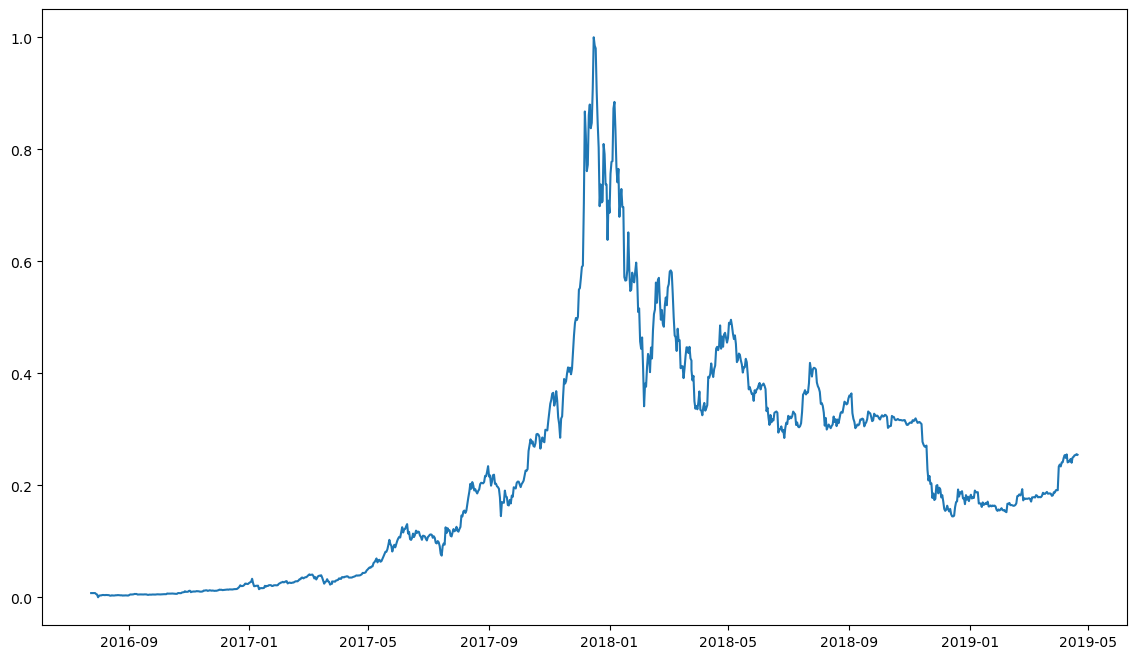

In [10]:
plt.figure(figsize=(14,8))
plt.plot(btc_df)
# 3 years bitcoin data 

In [11]:
def split_sequences(seq,n_steps_in,n_steps_out):
    # we feed it a sequence where we specify how may time steps goes in the sequence alongside how many comes out of the sequence 
    # lets say we want to predict 10 days then teh n_steps out will be 10 
    x,y=[],[]
    for i in range(len(seq)):
        end = i+n_steps_in
        # let's say from the sequence we put in 50 timesteps, basically we give 50 values of our prices from the past 
        # and then we want to preidct 
        out_end=end+n_steps_out
        if out_end > len(seq):
            break
        seq_x,seq_y=seq[i:end],seq[end:out_end]
        x.append(seq_x)# a lsit is getting appended in another list 
        y.append(seq_y)
        
    return np.array(x),np.array(y)

In [12]:
def visualize_results(results):
    history= results.history
    plt.figure(figsize=(14,8))
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss','loss'])
    plt.title('loss')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.show()
    
    plt.figure(figsize=(14,8))
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy','accuracy'])
    plt.title('accuracy')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.show()
    

In [17]:
# number of periods in 
n_per_in = 30 # let's say 30 days of stock price we have and we want to predict next 10 days 
n_per_out = 10
n_features= 1 # only one feature as closing price 

x,y=split_sequences(list(btc_df['Close']),n_per_in,n_per_out)
# basically what we are trying to achieve here is that, we will have our x in such a way that for every 30 days of data, we store the 
# next 10 days value in y, that s why there is an out_end statement comparison hapennig with seq 
# lstm requires a reshape 
print(x.shape)
x=x.reshape(x.shape[0],x.shape[1],n_features)
print(x.shape)

(961, 30)
(961, 30, 1)


In [18]:
x

array([[[0.00748458],
        [0.00749307],
        [0.0074713 ],
        ...,
        [0.00393159],
        [0.00372397],
        [0.00351687]],

       [[0.00749307],
        [0.0074713 ],
        [0.00754033],
        ...,
        [0.00372397],
        [0.00351687],
        [0.0034266 ]],

       [[0.0074713 ],
        [0.00754033],
        [0.00750369],
        ...,
        [0.00351687],
        [0.0034266 ],
        [0.00350148]],

       ...,

       [[0.17849666],
        [0.17922309],
        [0.17868517],
        ...,
        [0.24892285],
        [0.25385751],
        [0.24893027]],

       [[0.17922309],
        [0.17868517],
        [0.17884448],
        ...,
        [0.25385751],
        [0.24893027],
        [0.25515902]],

       [[0.17868517],
        [0.17884448],
        [0.18126801],
        ...,
        [0.24893027],
        [0.25515902],
        [0.24081965]]])

In [21]:
model2=Sequential()
model2.add(LSTM(30,activation='softsign',return_sequences=True,input_shape=(n_per_in,n_features)))# for input shape the model doesn't 
# need rows in the datset,
# activation function softsign:- 
# The Softsign function is an activation function which rescales the values between -1 and 1 by applying a threshold just like a sigmoid function. The advantage, that is, 
# the value of a softsign is zero-centered which helps the next neuron during propagating
model2.add(LSTM(30,activation='softsign',return_sequences=True))
model2.add(LSTM(30,activation='softsign',return_sequences=True))
model2.add(LSTM(30,activation='softsign',return_sequences=True))
model2.add(LSTM(30,activation='softsign',return_sequences=True))
model2.add(LSTM(10,activation='softsign'))
model2.add(Dense(n_per_out))
# the same number of outputs that we require from the dense layer 
model2.summary()




Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 30, 30)            3840      
                                                                 
 lstm_6 (LSTM)               (None, 30, 30)            7320      
                                                                 
 lstm_7 (LSTM)               (None, 30, 30)            7320      
                                                                 
 lstm_8 (LSTM)               (None, 30, 30)            7320      
                                                                 
 lstm_9 (LSTM)               (None, 30, 30)            7320      
                                                                 
 lstm_10 (LSTM)              (None, 10)                1640      
                                                                 
 dense (Dense)               (None, 10)               

In [22]:
model2.compile(optimizer='adam',loss='mse',metrics=['accuracy'])
# need to study about optimizer

In [27]:
res= model2.fit(x,y,epochs=500,batch_size=32,validation_split=0.1)
# validation split is something on which the model will be tuned based on the first training set  

Epoch 1/500
27/27 [==============================] - 2s 65ms/step - loss: 2.5168e-05 - accuracy: 0.4641 - val_loss: 5.8969e-04 - val_accuracy: 0.1753
Epoch 2/500
27/27 [==============================] - 2s 61ms/step - loss: 2.5575e-05 - accuracy: 0.4826 - val_loss: 5.4466e-04 - val_accuracy: 0.1546
Epoch 3/500
27/27 [==============================] - 2s 64ms/step - loss: 3.4867e-05 - accuracy: 0.4444 - val_loss: 5.1154e-04 - val_accuracy: 0.1546
Epoch 4/500
27/27 [==============================] - 2s 60ms/step - loss: 4.7689e-05 - accuracy: 0.4375 - val_loss: 6.0475e-04 - val_accuracy: 0.1546
Epoch 5/500
27/27 [==============================] - 2s 60ms/step - loss: 4.4050e-05 - accuracy: 0.4306 - val_loss: 5.6660e-04 - val_accuracy: 0.1546
Epoch 6/500
27/27 [==============================] - 2s 60ms/step - loss: 3.5572e-05 - accuracy: 0.4722 - val_loss: 5.8472e-04 - val_accuracy: 0.1649
Epoch 7/500
27/27 [==============================] - 2s 60ms/step - loss: 3.0267e-05 - accuracy: 0.4

27/27 [==============================] - 2s 60ms/step - loss: 2.3268e-05 - accuracy: 0.5023 - val_loss: 5.8244e-04 - val_accuracy: 0.1649
Epoch 110/500
27/27 [==============================] - 2s 60ms/step - loss: 2.3207e-05 - accuracy: 0.4664 - val_loss: 6.0170e-04 - val_accuracy: 0.1753
Epoch 111/500
27/27 [==============================] - 2s 61ms/step - loss: 2.3013e-05 - accuracy: 0.4988 - val_loss: 5.8305e-04 - val_accuracy: 0.1546
Epoch 112/500
27/27 [==============================] - 2s 60ms/step - loss: 2.2590e-05 - accuracy: 0.4850 - val_loss: 5.8743e-04 - val_accuracy: 0.1649
Epoch 113/500
27/27 [==============================] - 2s 60ms/step - loss: 2.3549e-05 - accuracy: 0.4896 - val_loss: 5.8727e-04 - val_accuracy: 0.1340
Epoch 114/500
27/27 [==============================] - 2s 62ms/step - loss: 2.4387e-05 - accuracy: 0.4780 - val_loss: 5.7462e-04 - val_accuracy: 0.1649
Epoch 115/500
27/27 [==============================] - 2s 60ms/step - loss: 2.3784e-05 - accuracy: 0.4

Epoch 163/500
27/27 [==============================] - 2s 60ms/step - loss: 2.2786e-05 - accuracy: 0.4838 - val_loss: 5.8728e-04 - val_accuracy: 0.1856
Epoch 164/500
27/27 [==============================] - 2s 60ms/step - loss: 2.3294e-05 - accuracy: 0.4884 - val_loss: 5.9784e-04 - val_accuracy: 0.1443
Epoch 165/500
27/27 [==============================] - 2s 60ms/step - loss: 2.3277e-05 - accuracy: 0.4699 - val_loss: 5.6444e-04 - val_accuracy: 0.1856
Epoch 166/500
27/27 [==============================] - 2s 60ms/step - loss: 2.2349e-05 - accuracy: 0.4803 - val_loss: 5.9034e-04 - val_accuracy: 0.1753
Epoch 167/500
27/27 [==============================] - 2s 60ms/step - loss: 2.2729e-05 - accuracy: 0.4896 - val_loss: 5.8606e-04 - val_accuracy: 0.2062
Epoch 168/500
27/27 [==============================] - 2s 60ms/step - loss: 2.2274e-05 - accuracy: 0.4803 - val_loss: 5.5850e-04 - val_accuracy: 0.1753
Epoch 169/500
27/27 [==============================] - 2s 61ms/step - loss: 2.2271e-05 -

Epoch 217/500
27/27 [==============================] - 2s 61ms/step - loss: 2.4544e-05 - accuracy: 0.4745 - val_loss: 6.0615e-04 - val_accuracy: 0.1443
Epoch 218/500
27/27 [==============================] - 2s 60ms/step - loss: 2.4333e-05 - accuracy: 0.4769 - val_loss: 5.7975e-04 - val_accuracy: 0.1649
Epoch 219/500
27/27 [==============================] - 2s 60ms/step - loss: 2.4200e-05 - accuracy: 0.4965 - val_loss: 5.7481e-04 - val_accuracy: 0.1856
Epoch 220/500
27/27 [==============================] - 2s 60ms/step - loss: 2.7940e-05 - accuracy: 0.4606 - val_loss: 5.3141e-04 - val_accuracy: 0.1753
Epoch 221/500
27/27 [==============================] - 2s 61ms/step - loss: 2.9196e-05 - accuracy: 0.4352 - val_loss: 5.9826e-04 - val_accuracy: 0.1340
Epoch 222/500
27/27 [==============================] - 2s 65ms/step - loss: 2.7233e-05 - accuracy: 0.4769 - val_loss: 6.4605e-04 - val_accuracy: 0.1649
Epoch 223/500
27/27 [==============================] - 2s 61ms/step - loss: 2.4920e-05 -

Epoch 271/500
27/27 [==============================] - 2s 61ms/step - loss: 2.4502e-05 - accuracy: 0.4850 - val_loss: 6.3099e-04 - val_accuracy: 0.1546
Epoch 272/500
27/27 [==============================] - 2s 60ms/step - loss: 2.3754e-05 - accuracy: 0.4942 - val_loss: 5.9644e-04 - val_accuracy: 0.1856
Epoch 273/500
27/27 [==============================] - 2s 60ms/step - loss: 2.4302e-05 - accuracy: 0.4618 - val_loss: 5.8081e-04 - val_accuracy: 0.1546
Epoch 274/500
27/27 [==============================] - 2s 60ms/step - loss: 2.3960e-05 - accuracy: 0.4861 - val_loss: 5.9803e-04 - val_accuracy: 0.1546
Epoch 275/500
27/27 [==============================] - 2s 60ms/step - loss: 2.3675e-05 - accuracy: 0.4988 - val_loss: 6.4507e-04 - val_accuracy: 0.1649
Epoch 276/500
27/27 [==============================] - 2s 66ms/step - loss: 2.4556e-05 - accuracy: 0.4803 - val_loss: 5.8213e-04 - val_accuracy: 0.1340
Epoch 277/500
27/27 [==============================] - 2s 61ms/step - loss: 2.5428e-05 -

Epoch 325/500
27/27 [==============================] - 2s 61ms/step - loss: 2.8093e-05 - accuracy: 0.4907 - val_loss: 5.4493e-04 - val_accuracy: 0.1443
Epoch 326/500
27/27 [==============================] - 2s 60ms/step - loss: 2.4252e-05 - accuracy: 0.4838 - val_loss: 5.9670e-04 - val_accuracy: 0.1649
Epoch 327/500
27/27 [==============================] - 2s 60ms/step - loss: 2.3420e-05 - accuracy: 0.4907 - val_loss: 5.8628e-04 - val_accuracy: 0.1649
Epoch 328/500
27/27 [==============================] - 2s 60ms/step - loss: 2.2823e-05 - accuracy: 0.4988 - val_loss: 5.6695e-04 - val_accuracy: 0.1546
Epoch 329/500
27/27 [==============================] - 2s 60ms/step - loss: 2.2377e-05 - accuracy: 0.4850 - val_loss: 5.8809e-04 - val_accuracy: 0.1546
Epoch 330/500
27/27 [==============================] - 2s 60ms/step - loss: 2.2924e-05 - accuracy: 0.4664 - val_loss: 5.7698e-04 - val_accuracy: 0.1546
Epoch 331/500
27/27 [==============================] - 2s 61ms/step - loss: 2.3458e-05 -

Epoch 379/500
27/27 [==============================] - 2s 60ms/step - loss: 5.1832e-05 - accuracy: 0.4468 - val_loss: 5.7439e-04 - val_accuracy: 0.1856
Epoch 380/500
27/27 [==============================] - 2s 61ms/step - loss: 3.5391e-05 - accuracy: 0.4502 - val_loss: 6.6119e-04 - val_accuracy: 0.1546
Epoch 381/500
27/27 [==============================] - 2s 60ms/step - loss: 2.8383e-05 - accuracy: 0.4826 - val_loss: 5.8151e-04 - val_accuracy: 0.1546
Epoch 382/500
27/27 [==============================] - 2s 60ms/step - loss: 2.6500e-05 - accuracy: 0.4988 - val_loss: 5.9705e-04 - val_accuracy: 0.1546
Epoch 383/500
27/27 [==============================] - 2s 60ms/step - loss: 2.4319e-05 - accuracy: 0.4988 - val_loss: 5.7871e-04 - val_accuracy: 0.1649
Epoch 384/500
27/27 [==============================] - 2s 61ms/step - loss: 2.4258e-05 - accuracy: 0.4757 - val_loss: 5.9932e-04 - val_accuracy: 0.1546
Epoch 385/500
27/27 [==============================] - 2s 61ms/step - loss: 2.3085e-05 -

Epoch 433/500
27/27 [==============================] - 2s 60ms/step - loss: 2.6243e-05 - accuracy: 0.4954 - val_loss: 5.7529e-04 - val_accuracy: 0.1340
Epoch 434/500
27/27 [==============================] - 2s 61ms/step - loss: 2.5411e-05 - accuracy: 0.4850 - val_loss: 6.1486e-04 - val_accuracy: 0.1546
Epoch 435/500
27/27 [==============================] - 2s 60ms/step - loss: 2.3256e-05 - accuracy: 0.4884 - val_loss: 5.8812e-04 - val_accuracy: 0.1546
Epoch 436/500
27/27 [==============================] - 2s 60ms/step - loss: 2.3224e-05 - accuracy: 0.4826 - val_loss: 5.6310e-04 - val_accuracy: 0.1856
Epoch 437/500
27/27 [==============================] - 2s 60ms/step - loss: 2.2969e-05 - accuracy: 0.4919 - val_loss: 6.0208e-04 - val_accuracy: 0.1443
Epoch 438/500
27/27 [==============================] - 2s 60ms/step - loss: 2.2142e-05 - accuracy: 0.4815 - val_loss: 6.1107e-04 - val_accuracy: 0.1031
Epoch 439/500
27/27 [==============================] - 2s 60ms/step - loss: 2.2227e-05 -

Epoch 487/500
27/27 [==============================] - 2s 67ms/step - loss: 2.3593e-05 - accuracy: 0.5139 - val_loss: 6.0104e-04 - val_accuracy: 0.1546
Epoch 488/500
27/27 [==============================] - 2s 61ms/step - loss: 2.2797e-05 - accuracy: 0.4919 - val_loss: 5.8846e-04 - val_accuracy: 0.1649
Epoch 489/500
27/27 [==============================] - 2s 61ms/step - loss: 2.3591e-05 - accuracy: 0.4896 - val_loss: 5.9304e-04 - val_accuracy: 0.1856
Epoch 490/500
27/27 [==============================] - 2s 60ms/step - loss: 2.4005e-05 - accuracy: 0.4803 - val_loss: 5.7870e-04 - val_accuracy: 0.1340
Epoch 491/500
27/27 [==============================] - 2s 60ms/step - loss: 2.5797e-05 - accuracy: 0.4549 - val_loss: 5.7659e-04 - val_accuracy: 0.1443
Epoch 492/500
27/27 [==============================] - 2s 60ms/step - loss: 2.3541e-05 - accuracy: 0.5046 - val_loss: 6.5568e-04 - val_accuracy: 0.1753
Epoch 493/500
27/27 [==============================] - 2s 63ms/step - loss: 2.2718e-05 -

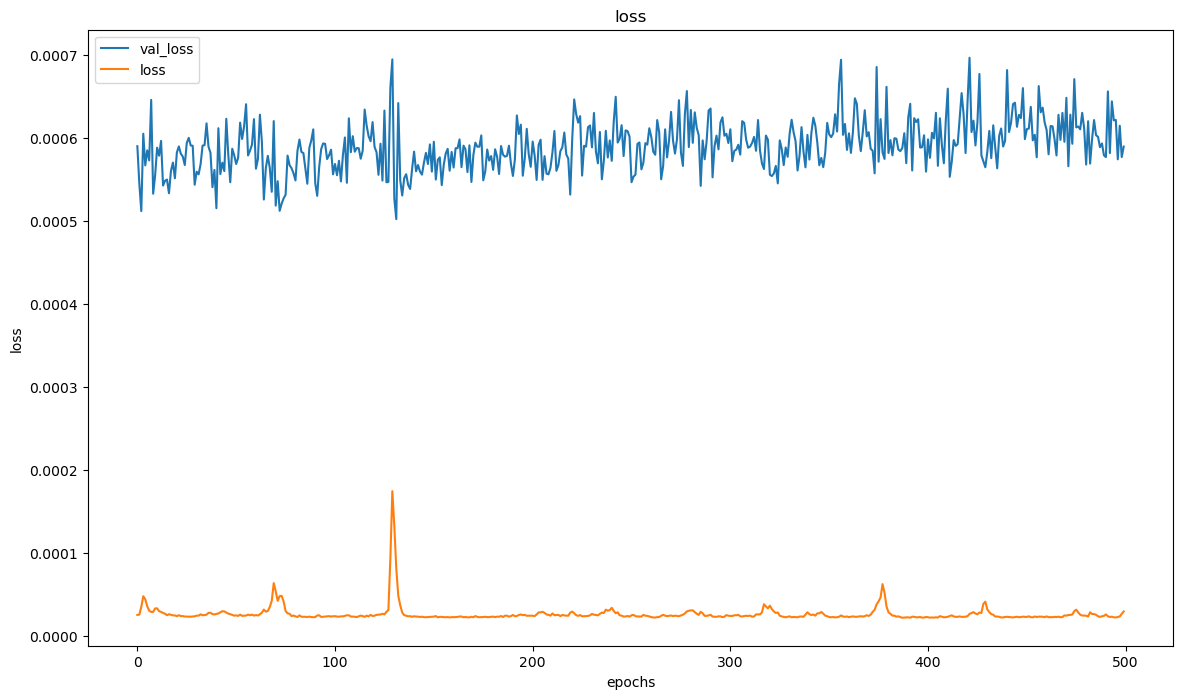

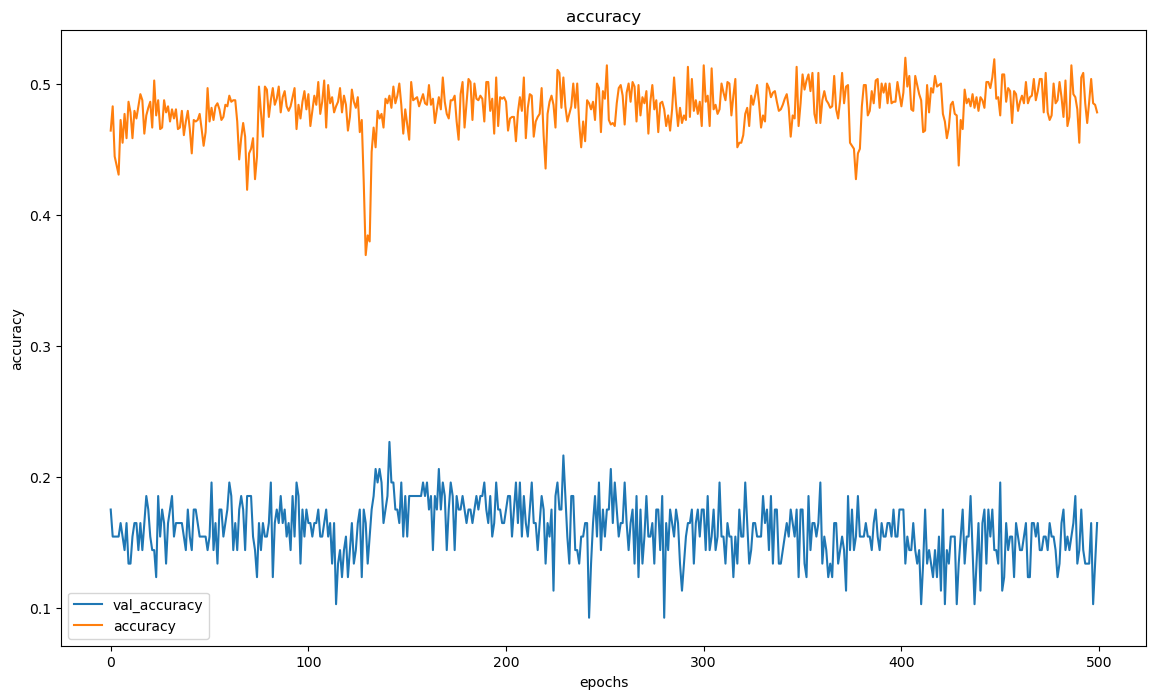

In [28]:
visualize_results(res)

1/1 [==============================] - 0s 45ms/step
predicted  [[5383.620712407019], [5712.928894721868], [6004.59757474794], [6031.356334013196], [6013.563931097236], [5880.640616662404], [6105.882716916716], [6276.138535835929], [6068.430107258403], [6075.560089172615]]
actuals  [[5081.5], [5080.660156], [5165.589844], [5037.27002], [5212.810059], [5236.259766000001], [5289.750000000001], [5295.529785], [5326.180176], [5305.740234]]


Text(0, 0.5, 'price ')

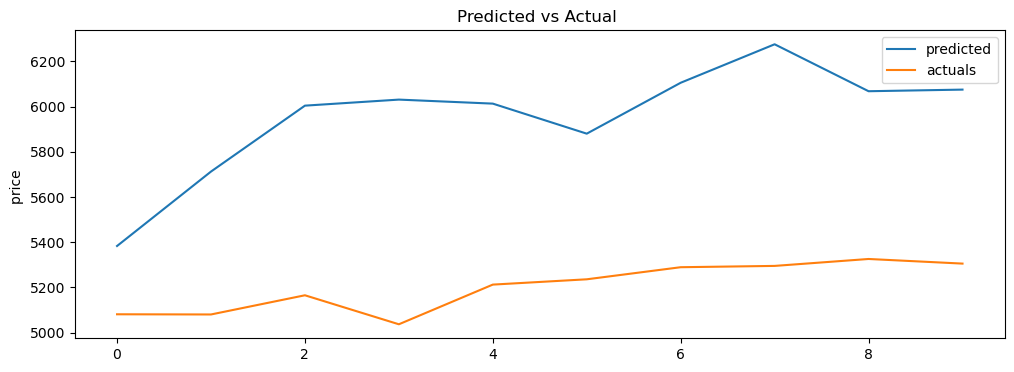

In [30]:
plt.figure(figsize=(12,4))
predict_res = model2.predict(x[-1].reshape(1,n_per_in,n_features)).tolist()[0]
# we need to unscale the data 
predict_res=scaler1.inverse_transform(np.array(predict_res).reshape(-1,1)).tolist() 
actual =scaler1.inverse_transform(y[-1].reshape(-1,1)).tolist()
print("predicted ", predict_res)
plt.plot(predict_res,label='predicted')
print("actuals ",actual)
plt.plot(actual,label='actuals')
plt.title("Predicted vs Actual ")
plt.legend()
plt.ylabel('price ')


In [33]:
# now for the actual predictions 
new_predictions = model2.predict(np.array(btc_df.tail(n_per_in)).reshape(1,n_per_in,n_features)).tolist()[0]

new_predictions=scaler1.inverse_transform(np.array(new_predictions).reshape(-1,1)).tolist()
preds = pd.DataFrame(new_predictions,index= pd.date_range(start=btc_df.index[-1], periods=len(new_predictions),freq='D'),columns=btc_df.columns)


# we are using the last 30 days entry  to get the next 10 days 

1/1 [==============================] - 0s 48ms/step


In [34]:
print(preds)

                  Close
2019-04-20  5988.882318
2019-04-21  6361.821791
2019-04-22  6570.374324
2019-04-23  6161.175996
2019-04-24  6285.909709
2019-04-25  6640.909735
2019-04-26  6493.722528
2019-04-27  6434.473636
2019-04-28  6119.253117
2019-04-29  5893.257272
